<a href="https://colab.research.google.com/github/RJuro/GA2019/blob/master/GA2019_Intro_to_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing some libraries that we are goint to use later
# seaborn (right version for plotting), hdbscan for clustering and rgeocoder for reverse geocoding offline
!pip3 install seaborn==0.9.0 hdbscan rgeocoder

     |████████████████████████████████| 4.0MB 2.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.1MB 30.5MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.22-cp36-cp36m-linux_x86_64.whl size=2336936 sha256=f4f9bbdb4f6a069712046cdda2a26bdf3963d825aa4df7da50bece89a2442c15
  Stored in directory: /root/.cache/pip/wheels/6d/f9/db/f2e5e704427932f5b05c91fc520effbb0bd10ba8d73fd3bfc7
Successfully built hdbscan


# A quick dive into nomad geography and the gig-economy
## Globelics Academy 2019 - Computational Methods Part2
### Roman Jurowetzki - 14/8 - 2019; roman@business.aau.dk

In this workshop you will learn how to work with dimensionality reduction and clustering techniques. We will have a look at data that comes in slightly different shapes and how we can aggregate it to identify latent patterns in a population.

We will use a dataset on cities worldwide to get familiar with dimensionality reduction.

We will use the same dataset to took into supervised machine learning.

Then, we will use a dataset of jobs performed by 1000 freelance-workers.

![](https://www.phocuswire.com/uploadedimages/uploads/2013/04/global-routes.jpg?width=800&height=400&scale=both&mode=crop)

There are many many ways to do similar things in Python and despite that we are not working with Natural Language Processing, we will use some tools and packages from this domeain for our analysis.

In [0]:
#Pandas handles tabular data
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Numpy for linear algebra & co
import numpy as np

#Gensim is actually an NLP library but we will use it here to construct BagOfJobs representations of freelancer portfolios.
import gensim
from gensim.corpora.dictionary import Dictionary

In [0]:
# We open the data directly from Github
cities = pd.read_csv('https://github.com/SDS-AAU/M1-2018/raw/master/data/nomad_cities.csv', sep='\t')

The data used in this tutorial is taken with permission form https://nomadlist.com/

In [4]:
# Let's have a quick look at the imported data
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 27 columns):
Unnamed: 0                781 non-null int64
coffee_in_cafe            781 non-null float64
cost_beer                 781 non-null float64
cost_coworking            781 non-null float64
cost_expat                781 non-null int64
cost_nomad                781 non-null int64
female_friendly           781 non-null float64
fragile_states_index      781 non-null object
free_wifi_available       781 non-null float64
freedom_score             781 non-null object
friendly_to_foreigners    781 non-null float64
internet_speed            781 non-null int64
latitude                  781 non-null float64
leisure                   781 non-null float64
lgbt_friendly             781 non-null float64
life_score                781 non-null float64
longitude                 781 non-null float64
nightlife                 781 non-null float64
nomadScore                781 non-null float64
nomad_score 

For some reason (data is messy) we have the name of the city as well as longitude/langitude but we don't have the country or region names.
Let's try to fix that.

One approach could be based on the lon/lat values, as city names may non-unique.

For this we need to start by "looking up" the country name for each specific coordinate

We can use an offline reverse geocoder package for that.

In [0]:
#Load and instantiate the reversegeocoder

from rgeocoder import ReverseGeocoder
rg = ReverseGeocoder()

In [0]:
# That's how it works

location = rg.nearest(61.4978, 23.7610) #lat, lon

In [7]:
# Let's see what we get
print(location.name)
print(location.admin1)
print(location.admin2)
print(location.cc)

Tampere
Pirkanmaa
Tampere
FI


In [0]:
# A smart way to get all geocoding done in one line

cities['alpha-2'] = cities.apply(lambda t: rg.nearest(t['latitude'],t['longitude']).cc, axis=1)

in the above cell we apply the 


```
rg.nearest(t['latitude'],t['longitude']).cc
```

function to each row t of the dataframe cities


```
lambda t:
```

is a rather scary syntactic way of calling an anonymous function

Basically, we could say:


*   For each row of the cities dataframe
*   take the value of the longitude and latitude columns
*   look up the corresponding place
*   write the country code "cc" into a new column "alpha-2"

Now that we have exact country codes for each city, we need to find the regions these countries belong to

Luckily it's easy to find tables listing this information on the internet.




In [0]:
# Download a recent country info table
c = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')

In [10]:
# Quick check
c.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.000,34.000,nan
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.000,154.000,nan
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.000,39.000,nan
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.000,15.000,nan
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.000,61.000,nan


In [0]:
# Cut out the alpha-2 iso and the region columns
c = c[['alpha-2','region','sub-region']]

In [0]:
 # Merge this lookup table with our initial cities list
 cities = cities.merge(c)

In [0]:
# Let's select interesting variables for the analysis

vars_analysis = ["cost_nomad", "cost_coworking", "cost_expat", "coffee_in_cafe", "cost_beer", # costs
          "places_to_work", "free_wifi_available", "internet_speed", # work
          "freedom_score", "peace_score", "safety", "fragile_states_index", "press_freedom_index", # safety & freedom
          "female_friendly", "lgbt_friendly", "friendly_to_foreigners", "racism", # friendly
          "leisure","life_score","nightlife","weed"] # fun 

vars_descr = ["nomad_score", "cost_nomad", "places_to_work", "freedom_score", "friendly_to_foreigners", "life_score"]

In [0]:
# And use the selection to only extract these variables into a new object

data = cities[vars_analysis]

descr = cities[vars_descr]

In [15]:
# Quick check

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 21 columns):
cost_nomad                780 non-null int64
cost_coworking            780 non-null float64
cost_expat                780 non-null int64
coffee_in_cafe            780 non-null float64
cost_beer                 780 non-null float64
places_to_work            780 non-null float64
free_wifi_available       780 non-null float64
internet_speed            780 non-null int64
freedom_score             780 non-null object
peace_score               780 non-null object
safety                    780 non-null float64
fragile_states_index      780 non-null object
press_freedom_index       780 non-null object
female_friendly           780 non-null float64
lgbt_friendly             780 non-null float64
friendly_to_foreigners    780 non-null float64
racism                    780 non-null float64
leisure                   780 non-null float64
life_score                780 non-null float64
nightlife   

We can see some strange things going with the data types. Some are floats or ints as we would expect but others are objects

In [16]:
print(data['peace_score'].unique())
print(data['freedom_score'].unique())
print(data['fragile_states_index'].unique())
print(data['press_freedom_index'].unique())

['0.8' '0.4' 'DotMap(__next__=DotMap())' 'DotMap()' '1' '0.6' '0.2']
['0.6' '0.2' '0.8' '0.4' '1' 'DotMap()']
['52.7' '78.8' '40.8' 'DotMap(__next__=DotMap())' 'DotMap()' '34' '23.8'
 '32.4' '74.2' '35.1' '65.3' '66.1' '39.8' '29.2' '29' '21.3' '22.6'
 '74.9' '84.7' '48.4' '28.6' '70.7' '22.5' '36.1' '28.2' '21.8' '39.6'
 '34.5' '43.1' '27.5' '110.8' '55.9' '53.2' '45.1' '52.9' '21.2' '70.4'
 '32.9' '40.7' '47.4' '43.4' '36.2' '75.5' '67' '73.9' '81' '79.6' '41.9'
 '72' '21.5' '69.6' '44.9' '77.3' '18.8' '64' '52.4' '33.9' '53.7' '78.9'
 '78' '42.4' '70.8' '65' '71.2' '44.5' '51.6' '75.6' '66.3' '80.2' '62'
 '24.1' '72.5' '72.6' '87.7' '55.2' '83.6' '43.2' '61.2' '63.4' '22.8'
 '72.2' '76.3' '66' '74' '73.2' '69.9' '90.7' '66.5' '87.4' '103.5' '98.3'
 '89.6' '78.5' '101.7' '79' '90.2' '56.6' '83.2' '96.3' '84.4' '74.6'
 '104.7' '95.2' '91.2' '78.3' '91.3' '83.5' '87.8' '84.2' '81.8' '97.2'
 '97.7' '79.8' '83.8' '86.9' '100.5' '103.8' '97.8' '90.5' '111.5' '81.6'
 '86.2' '91' '96.4' '93

This is a problem that probably has something to do with the scraping process. Let's try to turn everything into floats and if we can't we just put in a missing value statement

In [0]:
# This function will fo exactly that
def floater(x):
  try: #Try to
    return float(x) #Turn X into a floating point number
  except ValueError: #In case a ValueError occurs
    return np.nan #Turn X into np.nan (missing value placeholder)

In [18]:
data.loc[:,'peace_score'] = data['peace_score'].map(floater)
data.loc[:,'freedom_score'] = data['freedom_score'].map(floater)
data.loc[:,'fragile_states_index'] = data['fragile_states_index'].map(floater)
data.loc[:,'press_freedom_index'] = data['press_freedom_index'].map(floater)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now we are facing a new problem - Missing Data. While it would be easier to just kick out these cities, we will try to do better and impute.

In [19]:
# Import the imputation package
from fancyimpute import MatrixFactorization, SimpleFill

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [0]:
# Easy version: Just replace missing values by the mean of the column
data_imp = SimpleFill(fill_method='mean').fit_transform(data)

In [21]:
# We can have a quick look
pd.DataFrame(data_imp, columns=data.columns)

,cost_nomad,cost_coworking,cost_expat,coffee_in_cafe,cost_beer,places_to_work,free_wifi_available,internet_speed,freedom_score,peace_score,safety,fragile_states_index,press_freedom_index,female_friendly,lgbt_friendly,friendly_to_foreigners,racism,leisure,life_score,nightlife,weed
0,1364.000,152.410,1273.000,1.730,1.730,1.000,0.400,31.000,0.600,0.800,0.600,52.700,28.170,1.000,0.270,0.600,0.400,0.800,0.860,1.000,0.000
1,777.000,98.880,780.000,0.850,0.850,0.800,0.600,14.000,0.200,0.400,0.800,78.800,44.530,0.800,0.600,0.600,0.400,0.620,0.750,0.400,0.000
2,1012.000,155.430,1714.000,1.410,1.410,0.800,0.400,14.000,0.200,0.400,0.800,78.800,44.530,0.600,0.800,0.600,0.420,0.600,0.750,0.820,0.000
3,1197.000,131.410,1158.000,2.120,2.120,1.000,1.000,24.000,0.200,0.400,0.770,78.800,44.530,0.800,0.800,1.000,0.420,0.820,0.720,1.000,0.000
4,1352.000,169.560,1347.000,1.410,1.410,0.800,0.400,15.000,0.200,0.400,0.800,78.800,44.530,0.800,0.800,1.000,0.400,0.800,0.800,0.800,0.000
5,812.000,135.650,1016.000,1.410,1.410,0.400,0.200,15.000,0.200,0.400,0.800,78.800,44.530,1.000,0.800,0.800,0.400,0.620,0.730,0.430,0.000
6,1134.000,195.380,1119.000,1.410,1.410,0.600,0.600,12.000,0.200,0.400,0.600,78.800,44.530,0.600,0.400,1.000,0.600,0.800,0.760,0.800,0.000
7,1134.000,113.040,1100.000,2.120,2.120,0.400,0.600,9.000,0.200,0.400,0.560,78.800,44.530,0.200,1.000,1.000,0.400,0.800,0.660,0.800,0.000
8,866.000,172.390,1483.000,1.840,1.840,0.400,0.400,0.000,0.200,0.400,0.600,78.800,44.530,0.600,0.400,0.800,0.400,0.600,0.700,0.400,0.000
9,1232.000,172.390,2173.000,1.550,1.550,0.400,0.400,13.000,0.200,0.400,0.400,78.800,44.530,0.600,0.400,0.600,0.600,0.600,0.660,0.600,0.000


In [22]:
# Or, we go crazy and use a neural network powered method
data_imp = MatrixFactorization().fit_transform(data)

W0809 13:09:34.547072 140600259549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 13:09:34.580251 140600259549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 13:09:34.587649 140600259549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0809 13:09:34.666552 140600259549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 13:09:34.952594 140600259549056 deprecation_wrapper.

Train on 14675 samples, validate on 1631 samples
Epoch 1/10000
14675/14675 [==============================] - 1s 42us/step - loss: 1.0904 - val_loss: 1.0715
Epoch 2/10000
14675/14675 [==============================] - 0s 2us/step - loss: 1.0867 - val_loss: 1.0705
Epoch 3/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0844 - val_loss: 1.0695
Epoch 4/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0823 - val_loss: 1.0686
Epoch 5/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0803 - val_loss: 1.0677
Epoch 6/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0784 - val_loss: 1.0668
Epoch 7/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0764 - val_loss: 1.0659
Epoch 8/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0744 - val_loss: 1.0650
Epoch 9/10000
14675/14675 [==============================] - 0s 1us/step - loss: 1.0724 - val_

In [23]:
# Let's check descriptive stats for all variables
pd.DataFrame(data_imp, columns = data.columns).describe()

,cost_nomad,cost_coworking,cost_expat,coffee_in_cafe,cost_beer,places_to_work,free_wifi_available,internet_speed,freedom_score,peace_score,safety,fragile_states_index,press_freedom_index,female_friendly,lgbt_friendly,friendly_to_foreigners,racism,leisure,life_score,nightlife,weed
count,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000
mean,2331.749,210.269,1880.914,3.297,3.297,0.572,0.561,13.604,0.478,0.675,0.678,55.582,34.970,0.645,0.546,0.737,23310023310023078484901888.000,0.631,0.701,0.605,0.117
std,1118.123,174.072,1266.151,1.983,1.983,0.220,0.240,18.206,0.247,0.223,0.210,23.361,19.490,0.248,0.244,0.184,651013521854020967731298304.000,0.201,0.148,0.234,0.321
min,387.000,0.010,296.000,0.000,0.000,0.000,0.000,0.000,0.186,0.200,0.000,18.800,-0.263,0.000,0.180,0.000,0.000,0.000,0.010,0.000,0.000
25%,1486.000,88.960,1010.000,1.600,1.600,0.400,0.400,2.000,0.200,0.560,0.600,34.000,22.490,0.440,0.400,0.600,0.400,0.450,0.620,0.400,0.000
50%,2208.500,171.300,1646.000,3.060,3.060,0.400,0.600,6.000,0.600,0.800,0.600,54.494,28.930,0.600,0.600,0.800,0.600,0.600,0.720,0.600,0.000
75%,3057.000,275.962,2409.750,4.622,4.622,0.800,0.800,19.250,0.600,0.800,0.800,74.900,44.530,0.800,0.800,0.800,0.800,0.800,0.810,0.800,0.000
max,10121.000,1524.460,13406.000,13.720,13.720,1.000,1.000,197.000,1.000,1.099,1.000,111.500,83.760,1.000,1.000,1.000,18181818181818001939777978368.000,1.000,1.000,1.000,1.000


Before doing any kind of machine learning, especially when using neural networks and similar, it is important to normalise the data. One good way of doing it is using standardisation.
From each value we substract the sample mean and divide by the standard deviation.

In [0]:
# Let's standard-scale our data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data_imp)

As you can see, now our data has a mean of 0 and a standard deviation of one.

In [25]:
pd.DataFrame(data_scaled, columns=data.columns).describe()

,cost_nomad,cost_coworking,cost_expat,coffee_in_cafe,cost_beer,places_to_work,free_wifi_available,internet_speed,freedom_score,peace_score,safety,fragile_states_index,press_freedom_index,female_friendly,lgbt_friendly,friendly_to_foreigners,racism,leisure,life_score,nightlife,weed
count,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000,780.000
mean,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-1.740,-1.209,-1.253,-1.664,-1.664,-2.598,-2.344,-0.748,-1.183,-2.126,-3.229,-1.576,-1.809,-2.609,-1.498,-4.008,-0.036,-3.140,-4.673,-2.587,-0.363
25%,-0.757,-0.697,-0.688,-0.856,-0.856,-0.780,-0.674,-0.638,-1.126,-0.514,-0.372,-0.924,-0.641,-0.830,-0.596,-0.744,-0.036,-0.900,-0.545,-0.878,-0.363
50%,-0.110,-0.224,-0.186,-0.119,-0.119,-0.780,0.161,-0.418,0.493,0.562,-0.372,-0.047,-0.310,-0.184,0.223,0.344,-0.036,-0.153,0.132,-0.023,-0.363
75%,0.649,0.378,0.418,0.669,0.669,1.038,0.996,0.310,0.493,0.562,0.580,0.827,0.491,0.625,1.043,0.344,-0.036,0.843,0.741,0.831,-0.363
max,6.971,7.555,9.108,5.260,5.260,1.946,1.832,10.080,2.112,1.902,1.532,2.395,2.505,1.433,1.863,1.432,27.911,1.838,2.027,1.686,2.752


Let's try out dimensionality reduction with Principle Component Analysis: PCA
Check out this for details on PCA: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


Want to know more about dimensionality reduction?
https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/


In [0]:
# Import the module and instantiate a PCA object
from sklearn.decomposition import PCA
pca = PCA(n_components=7) #We pick 7 as the number of components...just because (it's a 3rd of the columns available)

# Fit and transform the data
data_reduced = pca.fit_transform(data_scaled)

In [0]:
# We could also try a very new fancy technique for DR (which we are going to use later anyway)

import umap
data_reduced = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=7).fit_transform(data_scaled)

In [56]:
# Make sure the data shape is as it should be
data_reduced.shape

(780, 7)

In [57]:
# Is 7 components really a good choice?
pca.explained_variance_ratio_

array([0.41450244, 0.09391145, 0.06111015, 0.05353052, 0.04771027,
       0.04194139, 0.03690729])

In [58]:
# How mach "information" do we kick out?
pca.explained_variance_ratio_.sum()

0.7496135027835716

Reducing the dimensionality is a nice way to make the data more approachable. In the present case, 21 variables is not a large number. However, the initial number of variables may be much higher (as we will see in the next dataset)

Now we can cluster the data using the most common and simple K-means algorithm.
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html


In [136]:
# Let's cluster our data
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=3)

clusterer.fit(data_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# Let's plot data using the first vs. second dimension of the PCA reduced data
import matplotlib.pyplot as plt
import seaborn as sns

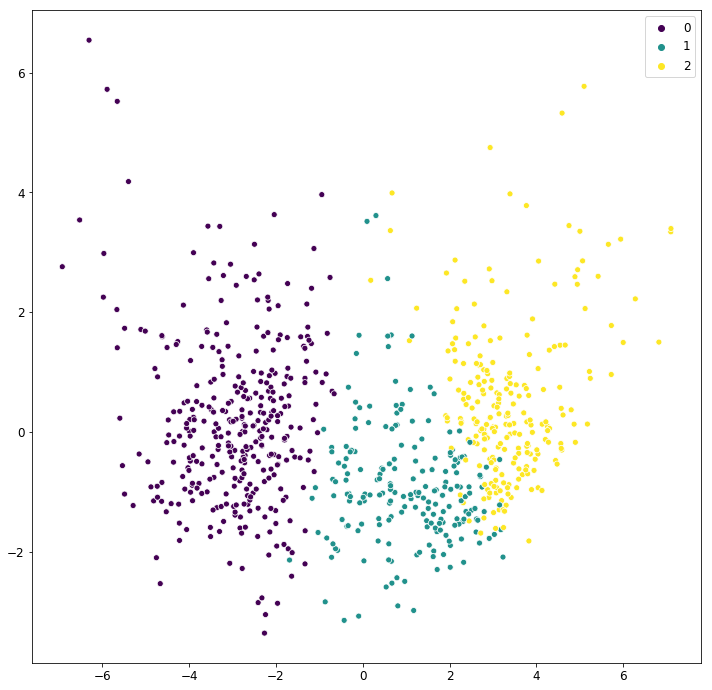

In [138]:
# Now we can plot in our points with some coloring

plt.figure(figsize=(12,12))

g = sns.scatterplot(data_reduced[:,0], data_reduced[:,1], hue=clusterer.labels_,
               legend='full', palette='viridis')

legend = g.get_legend()

We can certainly make things much more fancy. However, as you can see, that will require more work.

We can use Bokeh for an interactive visualisation.

In [0]:
# Load the needed bokeh modules

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap

In [0]:
# Define the data that we are going to use as a dictionary

d = {'y':data_reduced[:,1],'x':data_reduced[:,0], 'place': cities.place, 
     'cluster': pd.Series(clusterer.labels_).map({0:'a',1:'b',2:'c'}),
     'country':cities['alpha-2'],
     'region':cities['sub-region']}

In [0]:
# Defineand transform a color-palette

colors = factor_cmap('cluster', palette=Spectral6, factors=d['cluster'].unique())

In [0]:
# Transform the data to Bokeh format
d = ColumnDataSource(d)

In [143]:
# Define interactive tooling and plot for notebook output

output_notebook()

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select"
p = figure(tools=TOOLS)
p.hover.tooltips = [('Place', "@place"),('Country', "@country"),('Region', "@region")]
p.scatter(x='x', y='y',fill_alpha=0.8,
          color = colors,
          line_color = None,
          radius = 0.1,
          source=d)
show(p)

In [39]:
# Let's write our cluster numbers into the initial "real data"

descr['cluster'] = clusterer.labels_
cities['cluster'] = clusterer.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
# Now we can try out some basic descriptive statistics

descr.groupby('cluster').mean()

,nomad_score,cost_nomad,places_to_work,friendly_to_foreigners,life_score
cluster,,,,,
0,0.726,2999.990,0.634,0.790,0.804
1,0.570,1661.322,0.497,0.681,0.598
2,0.766,3219.046,0.732,0.822,0.833


In [41]:
# Which cluster ranks lowest when it comes to the nomad score? And what are the cities in this cluster?

cities[cities.cluster == 1].sort_values('nomad_score', ascending=True)['place'][:10]

751         Basra
779     Pyongyang
668          Cali
750       Baghdad
734    Bahawalpur
778      Damascus
733       Karachi
777       Tripoli
732    Gujranwala
731    Rawalpindi
Name: place, dtype: object

## Can we predict the region of a city only by looking at some of the indicators?

This part of the tutorial will be a short introduction to supervised ML. Why? Because instead of letting the computer split the data into some categories we are providing a model with outcome labels corresponding to some real observations. The model gets trained and we expect that it will be able to assign the categories observed during training to new data.

For this exercise we will use the data that already underwent dimensionality reduction.

We will then compare how we perfrom to a situation when we use original data.

To evaluate performance we will split the dataset into a training and a test-set. The test-set will be never shown to the ML algorithm and only used for evaluation.

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [0]:
# Encode the regions into indices
encoder = LabelEncoder()
y = encoder.fit_transform(cities.region)

# Split our data into training and test
# Here you can experiment by replacing data_reduced with data_scaled
X_train, X_test, y_train, y_test = train_test_split(data_reduced, y , test_size=0.33, random_state=42)



In [44]:
# Training a simple Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(multi_class='multinomial',solver='lbfgs')

classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# How are we doing?

from sklearn.metrics import classification_report

y_pred = classifier.predict(X_test)

classes_list = y_test.tolist() + y_pred.tolist()

labels = sorted(set(classes_list))
targets = encoder.inverse_transform(labels)

print(classification_report(y_test, y_pred, target_names = targets))

              precision    recall  f1-score   support

      Africa       0.33      0.25      0.29        12
    Americas       0.43      0.51      0.47        73
        Asia       0.67      0.75      0.71        77
      Europe       0.57      0.47      0.51        91
     Oceania       0.00      0.00      0.00         5

    accuracy                           0.55       258
   macro avg       0.40      0.40      0.39       258
weighted avg       0.54      0.55      0.54       258



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
import xgboost as xgb

In [47]:
classifier = xgb.XGBClassifier()

classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
# How are we doing?

y_pred = classifier.predict(X_test)

classes_list = y_test.tolist() + y_pred.tolist()

labels = sorted(set(classes_list))
targets = encoder.inverse_transform(labels)

print(classification_report(y_test, y_pred, target_names = targets))

              precision    recall  f1-score   support

      Africa       0.33      0.25      0.29        12
    Americas       0.56      0.68      0.61        73
        Asia       0.73      0.73      0.73        77
      Europe       0.75      0.65      0.69        91
     Oceania       0.00      0.00      0.00         5

    accuracy                           0.65       258
   macro avg       0.47      0.46      0.46       258
weighted avg       0.65      0.65      0.65       258



In [49]:
# Transforming nummerical labels to Regions and "confusion matrix"


df = pd.DataFrame({'true_region': encoder.inverse_transform(y_test), 'predicted_region': encoder.inverse_transform(y_pred)}) 
pd.crosstab(df.true_region, df.predicted_region)

predicted_region,Africa,Americas,Asia,Europe,Oceania
true_region,,,,,
Africa,3,5,4,0,0
Americas,4,50,5,13,1
Asia,1,17,56,3,0
Europe,0,18,12,59,2
Oceania,1,0,0,4,0


## Gig portfolios of online freelancers

![alt text](http://sds-datacrunch.aau.dk/public/adult-alone-bar-1308625.jpg)

You get gig-portfolio data for 1000 online freelancers – overall ~35k gigs. Given this data can you identify professional patterns?

This part of the tutorial is a short version based on the analysis performed for this paper:
**Career Paths in Digital Marketplaces: Same, same but different?**
With Mareike Seifried and Tobias Kretschmer
LMU Munich
Munich School of Management

 https://conference.druid.dk/acc_papers/48ox0g0vwmp0vvx8gj7lzwhbimflf0.pdf


In [0]:
# loading the data?
data = pd.read_csv('http://sds-datacrunch.aau.dk/public/feelance_eda.csv')

In [54]:
# Quick data exploration
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34606 entries, 0 to 34605
Data columns (total 13 columns):
Unnamed: 0          34606 non-null int64
as_job_type         34606 non-null object
as_opening_title    34606 non-null object
as_total_charge     25211 non-null float64
as_total_hours      14029 non-null float64
dev_country         34606 non-null object
econ_sit            34606 non-null object
fr_continent        34606 non-null object
skls_required_no    5659 non-null float64
sub_category        34606 non-null object
tenure_d            34374 non-null float64
hour_percent        34606 non-null float64
f_id                34606 non-null int64
dtypes: float64(5), int64(2), object(6)
memory usage: 3.4+ MB


In [52]:
data.head()

,Unnamed: 0,as_job_type,as_opening_title,as_total_charge,as_total_hours,dev_country,econ_sit,fr_continent,skls_required_no,sub_category,tenure_d,hour_percent,f_id
0,0,Hourly,Seo work. and outher stuff,941.500,269.000,India,Emerging/Developing,Asia,nan,SEO - Search Engine Optimization,574.000,0.929,0
1,1,Hourly,PPC Keyword Sorting for Neeraj Sunghal,25.000,5.000,India,Emerging/Developing,Asia,nan,Data Entry,574.000,0.929,0
2,2,Hourly,Shopify SEO Work Required,368.000,92.000,India,Emerging/Developing,Asia,nan,SEO - Search Engine Optimization,574.000,0.929,0
3,3,Hourly,Need help in listing and SEO and product manag...,146.740,22.000,India,Emerging/Developing,Asia,nan,SEO - Search Engine Optimization,574.000,0.929,0
4,4,Hourly,Need help with Adwords & Google Merchant Center,160.080,24.000,India,Emerging/Developing,Asia,nan,SEM - Search Engine Marketing,574.000,0.929,0


In [0]:
# How does one portfolio look like?
data[data.f_id == 78].sub_category

3455    Desktop Software Development
3456             Scripts & Utilities
3457             Scripts & Utilities
3458           Other - Admin Support
3459    Desktop Software Development
3460    Other - Software Development
3461                 Web Development
3462                 Web Development
3463                 Web Development
3464                 Web Development
3465                 Web Development
3466    Other - Software Development
3467                 Web Development
3468                 Web Development
3469                 Web Development
3470                 Web Development
3471                 Web Development
Name: sub_category, dtype: object

#### Assembling gig-portfolios from a gig-list

A bit some thing on loops and slightly more advanced  stuff.

the next couple of cells will show how you can 
- add stuff to lists and how to 
- work with loops

In [0]:
empty_list = []

print(empty_list)

[]


In [0]:
empty_list.append(1)

print(empty_list)

[1]


In [0]:
empty_list.append("i don't want to be in that list")

print(empty_list)

[1, "i don't want to be in that list"]


In [0]:
empty_list.append(['🙉','👽','🐼'])

print(empty_list)

[1, "i don't want to be in that list", ['🙉', '👽', '🐼']]


In [0]:
# Let's get the panda out! --> '🐼'
empty_list[2][2]

'🐼'

In [0]:
empty_list.extend(['🐧','🍅','🤘'])

print(empty_list)

[1, "i don't want to be in that list", ['🙉', '👽', '🐼'], '🐧', '🍅', '🤘']


In [0]:
# LOOPS

emoji_list = ['🙉', '👽', '🐼','🐧','🍅','🤘']


for some_emoji in emoji_list:
  print(50 * some_emoji)

🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉
👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽
🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼
🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧
🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅
🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘


In [0]:
# LIST COMPREHENSIONS (mini-loops in Python)

[50*x for x in emoji_list]

['🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉🙉',
 '👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽👽',
 '🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼',
 '🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧🐧',
 '🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅🍅',
 '🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘🤘']

From here we can try to assemble job-portfolios by making a list of lists with performed gigs for individual workers

In [0]:
# individual freelancers
workers = data.f_id.unique()

In [0]:
#create empty list
stuff_people_do = []

for some_worker_id in workers: #initiate loop
  stuff = list(data[data.f_id == some_worker_id].sub_category) # extract portfolio for a single worker
  stuff_people_do.append((some_worker_id, stuff)) # append portfolio to the list of portfolios

In [0]:
#use pandas to make it into a datafrmae
portfolios = pd.DataFrame(stuff_people_do, columns = ['f_id', 'gig_portfolio'])
#Calculate the most common gig_activity
portfolios['max'] = portfolios['gig_portfolio'].map(lambda t: max(t))

Now we are going to use Gensim (a library for Natural Language Processing) to transform these protfolio lists into BoW representations

In [0]:
# First we ceate a dicitonary - an index-subcategory mapping object

dictionary = Dictionary(portfolios['gig_portfolio'])

In [71]:
# quick check: it's as long as the number of uniques subcategories
len(dictionary)

86

In [72]:
data.sub_category.unique()

array(['SEO - Search Engine Optimization', 'Data Entry',
       'SEM - Search Engine Marketing', 'Display Advertising',
       'Article & Blog Writing', '3D Modeling & CAD', 'Web Development',
       'Web & Mobile Design', '.', 'General Translation', 'Presentations',
       'Ecommerce Development', 'Graphic Design',
       'Email & Marketing Automation', 'Other - Writing',
       'Editing & Proofreading', 'Creative Writing', 'Web Content',
       'QA & Testing', 'Web Research', 'Market & Customer Research',
       'Other - Sales & Marketing', 'Marketing Strategy', 'Copywriting',
       'Personal / Virtual Assistant', 'Other - Design & Creative',
       'Lead Generation', 'Logo Design & Branding',
       'SMM - Social Media Marketing', 'Voice Talent', 'Public Relations',
       'Photography', 'Audio Production', 'Animation',
       'Other - Accounting & Consulting', 'Other - Admin Support',
       'Academic Writing & Research', 'Mobile Development',
       'Video Production', 'Telemarke

In [73]:
len(set(data.sub_category))

86

In [0]:
# Create a "corpus of portfolios" in BoW format
corpus = [dictionary.doc2bow(sequence) for sequence in portfolios['gig_portfolio']]

In [75]:
# Transform corpus into a matrix 
portfolio_matrix = gensim.matutils.corpus2dense(corpus=corpus, num_terms=len(dictionary))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [76]:
portfolio_matrix.shape

(86, 1000)

In [0]:
# swap rows and columns with a transponse
portfolio_matrix = portfolio_matrix.T

Why should I trust this? Can we check if all the transformations didn't mess up things?

In [78]:
# portfolio of worker 0
portfolio_matrix[0]

array([1., 1., 1., 6., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [79]:
# what's the taks sub-category of index 3?
dictionary.get(3)

'SEM - Search Engine Marketing'

In [80]:
# How many times did the worker perform this gig?
data[data.f_id == 0].sub_category

0     SEO - Search Engine Optimization
1                           Data Entry
2     SEO - Search Engine Optimization
3     SEO - Search Engine Optimization
4        SEM - Search Engine Marketing
5        SEM - Search Engine Marketing
6        SEM - Search Engine Marketing
7        SEM - Search Engine Marketing
8                  Display Advertising
9        SEM - Search Engine Marketing
10    SEO - Search Engine Optimization
11    SEO - Search Engine Optimization
12              Article & Blog Writing
13       SEM - Search Engine Marketing
Name: sub_category, dtype: object

Now we sucessfully created "Bag-of-Gigs" representations of individual workers' portfolios
The matrix is however very sparse, as we can see (many zeros and  only some non-0 values) as one would expect that.
PCA is not a good choice here. Instead we will use Non-negative Matrix Factorization (NMF), which has the tendency to very well "squash" the data into interpretable latent themes:

In Natural Language Processing, such themes are called topics and what we are going to do now is referred to as Vector Space Modelling or Topic Modelling

The coolest thing about that identified components are very interopretable. This is because the model is build on assumptions about the world related to co-occurence.

In [0]:
# Let's try to bring it all the way down to 5 dimensions

from sklearn.decomposition import NMF

model = NMF(n_components=5)

portfolio_matrix_reduced = model.fit_transform(portfolio_matrix)

In [82]:
# what are these components?
model.components_.shape

(5, 86)

In [0]:
# Make a dataframe
components_df = pd.DataFrame(model.components_, columns=list(dictionary.values()))

In [84]:
components_df

,Article & Blog Writing,Data Entry,Display Advertising,SEM - Search Engine Marketing,SEO - Search Engine Optimization,.,3D Modeling & CAD,General Translation,Presentations,Web & Mobile Design,Web Development,Ecommerce Development,Email & Marketing Automation,Graphic Design,Other - Writing,Creative Writing,Editing & Proofreading,QA & Testing,Web Content,Web Research,Market & Customer Research,Copywriting,Lead Generation,Logo Design & Branding,Marketing Strategy,Other - Design & Creative,Other - Sales & Marketing,Personal / Virtual Assistant,Public Relations,SMM - Social Media Marketing,Voice Talent,Animation,Audio Production,Photography,Academic Writing & Research,Other - Accounting & Consulting,Other - Admin Support,Mobile Development,Video Production,Contract Law,...,Other - Software Development,Project Management,ERP / CRM Software,Data Mining & Management,Network & System Administration,Game Development,Quantitative Analysis,Other - Legal,Technical Writing,Data Visualization,Other - Data Science & Analytics,Scripts & Utilities,Technical Support,Product Design,Intellectual Property Law,Legal Translation,Product Management,Customer Service,Accounting,Database Administration,Other - IT & Networking,Data Extraction / ETL,Other - Engineering & Architecture,Human Resources,Other - Customer Service,Technical Translation,Machine Learning,Management Consulting,Civil & Structural Engineering,Information Security,Architecture,Grant Writing,Resumes & Cover Letters,Corporate Law,Medical Translation,Electrical Engineering,Interior Design,Family Law,Contract Manufacturing,Mechanical Engineering
0,0.108,0.170,0.020,0.006,0.000,0.027,0.342,0.000,0.578,0.589,0.250,0.000,0.000,23.349,0.135,0.000,0.065,0.000,0.123,0.000,0.008,0.008,0.000,9.242,0.004,0.210,0.000,0.000,0.000,0.046,0.051,0.254,0.034,0.449,0.029,0.000,0.104,0.090,0.240,0.003,...,0.000,0.000,0.000,0.000,0.000,0.077,0.005,0.019,0.010,0.000,0.000,0.000,0.005,0.026,0.004,0.000,0.000,0.003,0.045,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.002,0.000,0.004,0.000,0.004,0.000,0.000,0.012,0.006,0.000,0.000,0.002
1,0.337,0.036,0.014,0.178,0.682,0.162,0.180,0.000,0.000,4.600,21.983,1.791,0.089,0.000,0.132,0.000,0.051,0.118,0.105,0.000,0.000,0.030,0.000,0.059,0.009,0.044,0.001,0.117,0.000,0.061,0.040,0.129,0.036,0.000,0.097,0.015,0.036,0.650,0.218,0.012,...,0.520,0.058,0.041,0.010,0.974,0.049,0.069,0.020,0.021,0.048,0.073,0.396,0.015,0.011,0.004,0.000,0.038,0.000,0.076,0.043,0.035,0.020,0.004,0.002,0.002,0.000,0.001,0.000,0.005,0.041,0.018,0.000,0.004,0.001,0.000,0.011,0.011,0.000,0.000,0.002
2,4.762,0.000,0.001,0.000,0.041,0.573,0.007,0.000,0.019,0.000,0.410,0.062,0.000,0.379,1.709,18.982,0.566,0.044,0.562,0.031,0.039,0.291,0.000,0.000,0.012,0.000,0.007,0.281,0.004,0.020,0.084,0.098,0.030,0.002,0.288,0.000,0.010,0.000,0.252,0.045,...,0.000,0.002,0.000,0.000,0.000,0.002,0.000,0.014,0.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.007,0.014,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.003,0.022,0.000,0.000,0.002,0.000,0.000,0.000,0.000
3,1.916,0.000,0.001,0.000,0.081,0.188,0.002,18.487,0.085,0.000,0.205,0.000,0.000,0.000,0.865,0.000,0.394,0.139,0.524,0.104,0.041,0.184,0.000,0.000,0.007,0.018,0.024,0.075,0.003,0.021,2.441,0.054,0.129,0.028,0.129,0.015,0.041,0.000,0.543,0.056,...,0.000,0.002,0.000,0.000,0.000,0.000,0.010,0.074,0.060,0.000,0.002,0.000,0.018,0.011,0.005,0.155,0.000,0.053,0.003,0.000,0.002,0.000,0.001,0.004,0.031,0.246,0.000,0.004,0.000,0.000,0.000,0.027,0.012,0.001,0.007,0.000,0.000,0.001,0.000,0.000
4,1.847,12.811,0.044,0.036,0.620,0.172,0.006,0.000,0.127,0.000,0.628,0.368,0.242,0.593,0.749,0.000,0.119,0.029,0.356,6.709,0.361,0.103,2.847,0.000,0.050,0.330,0.141,1.275,0.019,0.289,0.000,0.000,0.015,0.055,0.276,0.032,0.650,0.028,0.047,0.032,...,0.169,0.036,0.003,0.059,0.000,0.000,0.209,0.033,0.059,0.086,0.046,0.821,0.005,0.001,0.008,0.000,0.009,0.110,0.113,0.011,0.006,0.058,0.010,0.016,0.004,0.000,0.000,0.003,0.001,0.000,0.004,0.002,0.0

In [86]:
# Select a component
component = components_df.iloc[0,:]

# Print result of nlargest
print(component.nlargest())

Graphic Design           23.349
Logo Design & Branding    9.242
Illustration              1.788
Web & Mobile Design       0.589
Presentations             0.578
Name: 0, dtype: float64


In [0]:
# Import clustering and dimensionality reduction
# HDBSCAN won't work with numpy < 1.16

import hdbscan
import umap

In [0]:
# Let's try not to overdo things and maybe keep it at 20 components

model = NMF(n_components=20)

portfolio_matrix_reduced = model.fit_transform(portfolio_matrix)

In [0]:
# Note that the standard setting of UMAP will produce 2 dimensions
embedding = umap.UMAP(n_neighbors=15, metric='cosine').fit_transform(portfolio_matrix_reduced)

You can read more about


- UMAP here: https://umap-learn.readthedocs.io/en/latest/
- HDBSCAN here: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

HDBSCAN is a recent hi-performance density based clustering approach


In [151]:
# Now, we will feed the 2-dimensional representation into HDBSCAN
# Warning can be ignored for now

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, 
                            min_samples=50, 
                            leaf_size=40, 
                            #core_dist_n_jobs=16, 
                            prediction_data=True)
clusterer.fit(embedding)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=50, p=None,
        prediction_data=True)

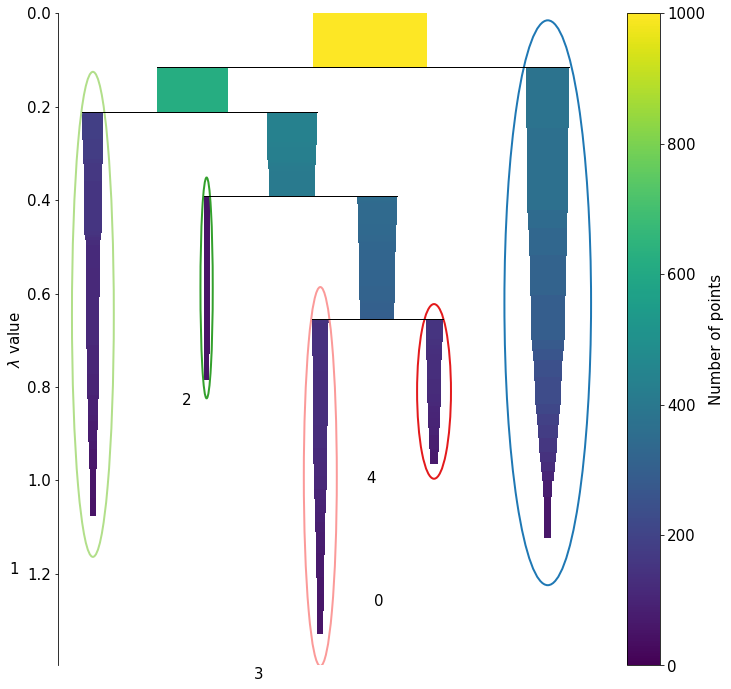

In [152]:
pal = sns.color_palette("Paired", n_colors = len(set(clusterer.labels_)))[1:]
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 15})
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=pal, label_clusters=True)

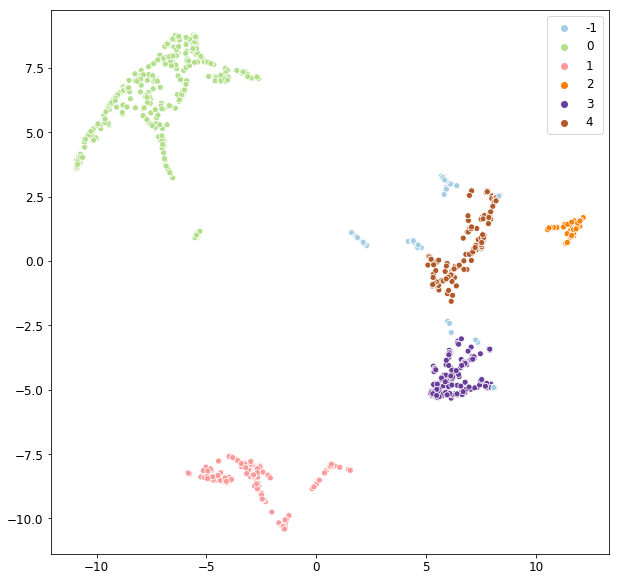

In [153]:
# Scatterplor of the UMAP embeddings with cluster-coloring
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,10))
g = sns.scatterplot(*embedding.T, 
                hue=clusterer.labels_, 
                legend='full',
                palette = 'Paired')
legend = g.get_legend()

In [0]:
# Define the data too use
d = {'x':embedding[:,0], 'y': embedding[:,1], 'activity' : portfolios['max'], 'cluster': [str(x) for x in clusterer.labels_]} 

In [0]:
# Defineand transform a color-palette

colors = factor_cmap('cluster', palette=Spectral6, factors=list(set(d['cluster'])))

In [0]:
# Transform the data to Bokeh format
d = ColumnDataSource(d)

In [169]:
# Define interactive tooling and plot for notebook output

output_notebook()

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select"
p2 = figure(tools=TOOLS)
p2.hover.tooltips = [('Activity', "@activity")]
p2.scatter(x='x', y='y',fill_alpha=0.8,
          color = colors,
          line_color = None,
          radius = 0.1,
          source=d)
show(p2)

In [0]:
portfolios['cluster'] = clusterer.labels_

In [0]:
import itertools

In [0]:
from collections import Counter

In [0]:
counter = Counter(list(itertools.chain(*portfolios[portfolios.cluster == 1]['gig_portfolio'])))

In [178]:
counter.most_common(20)

[('Graphic Design', 3244),
 ('Logo Design & Branding', 1264),
 ('Illustration', 624),
 ('Video Production', 587),
 ('Web Development', 383),
 ('Voice Talent', 274),
 ('Animation', 271),
 ('Web & Mobile Design', 196),
 ('Presentations', 154),
 ('Photography', 151),
 ('Other - Design & Creative', 127),
 ('Audio Production', 88),
 ('General Translation', 76),
 ('Data Entry', 71),
 ('Article & Blog Writing', 68),
 ('3D Modeling & CAD', 63),
 ('Other - Writing', 59),
 ('Mobile Development', 57),
 ('Game Development', 39),
 ('.', 33)]